In [1]:
import os
import sys
os.chdir("../")

In [2]:
from src.image_sharing_plateform.pipeline.stage_05_model_prediction_pipeline import PredictionPipeline
from src.image_sharing_plateform.constants import *
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D
import numpy as np
import os
from tqdm import tqdm
from PIL import Image
import tensorflow as tf
from src.image_sharing_plateform.model.cnn_lstm_model.model import CreateSqueezeModel, CreateLSTMSequence
from tensorflow.keras.models import load_model

In [3]:
prediction_pipeline = PredictionPipeline(PARAMS_FILE_PATH)

custom_objects = {
            "CreateSqueezeModel":CreateSqueezeModel,
            "CreateLSTMSequence": CreateLSTMSequence,
        }

In [4]:
model = prediction_pipeline.return_trained_model()

data/trained_model/cnn_lstm_model/trained_model.h5


In [5]:
from keras.utils import plot_model

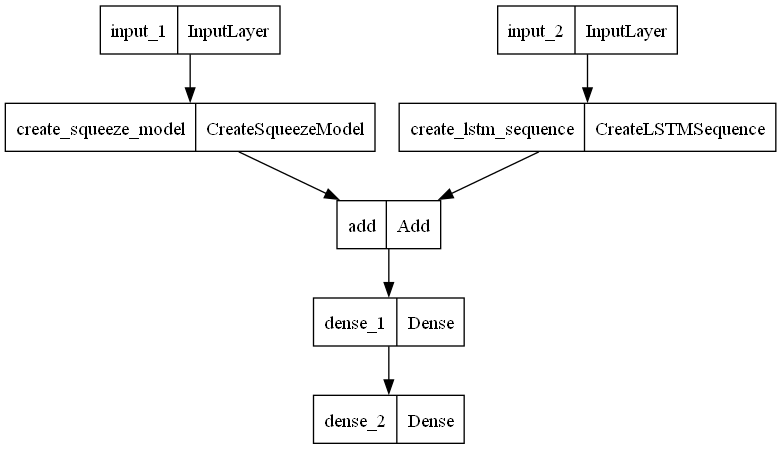

In [6]:
plot_model(model)

In [7]:
def extract_features(filename):
       
        # Load VGG16 model without top layers
        base_model = VGG16(input_shape=(500, 500, 3), 
                           include_top=False, weights='imagenet')

        model = tf.keras.Sequential([
            base_model,
            GlobalAveragePooling2D()  # Converts spatial dimensions to (batch_size, 512)
        ])

        features = {}
        
        image = Image.open(filename)
        image = image.resize((500,500))
        image = np.array(image) / 255.0  # Normalize correctly
        image = np.expand_dims(image, axis=0)  # Add batch dimension
            
        # Extract feature and flatten it
        feature = model.predict(image)  # Shape: (1, 512)
        
        return feature

In [8]:
extracted_feature = extract_features(r"U:\nlp_project\Image_Sharing_Plateform\data\row\Flickr8k_Dataset\Flicker8k_Dataset\3672940355_47f30e2b28.jpg")

1/1 [==============================] - 5s 5s/step


In [9]:
extracted_feature

array([[1.64685607e-01, 0.00000000e+00, 1.61697805e-01, 1.41706225e-02,
        8.80305916e-02, 0.00000000e+00, 6.46095769e-03, 2.93563157e-02,
        2.64002588e-02, 5.14066555e-02, 1.60867453e-03, 8.80766846e-03,
        9.24652666e-02, 0.00000000e+00, 2.59486437e-02, 3.11700195e-01,
        1.06079374e-02, 1.46009371e-01, 5.92744630e-03, 8.27578232e-02,
        0.00000000e+00, 0.00000000e+00, 3.25557077e-03, 2.33688608e-01,
        5.11255860e-02, 2.69934582e-03, 2.08756447e-01, 1.37584731e-01,
        1.26373649e-01, 5.34814643e-03, 5.17362356e-02, 2.61354983e-01,
        1.66324139e-01, 1.25673860e-01, 2.09829196e-01, 5.31975133e-03,
        1.60919651e-01, 3.05493991e-03, 0.00000000e+00, 1.00322696e-03,
        2.72303764e-02, 8.13035481e-03, 1.70541242e-01, 3.96267697e-02,
        1.69844568e-01, 1.16709396e-01, 2.06408918e-01, 6.08945079e-02,
        1.30914878e-02, 2.16104791e-01, 8.40560421e-02, 0.00000000e+00,
        1.78438500e-01, 9.23440035e-04, 3.02615063e-03, 6.360768

In [10]:
extracted_feature.shape

(1, 512)

In [11]:
from tensorflow.keras.models import load_model

# Load the model containing the TextVectorization layer
loaded_model = load_model(r"U:\nlp_project\Image_Sharing_Plateform\data\processed\vectorizer")

# Extract the TextVectorization layer
vectorizer = loaded_model.layers[0]

In [12]:
vectorizer

In [13]:
vocab = vectorizer.get_vocabulary()

In [14]:
def generate_caption(model, image_feature, vocab):
    """Generate a caption for the given image feature vector."""
    # sequence = vectorizer('<start>')  # Start with "<start>" token
    # sequence = vectorizer(tf.convert_to_tensor(["<start>"]))

    sequence = vectorizer(tf.convert_to_tensor(["<start>"]))  # Convert "<start>" to tensor
    sequence = sequence.numpy()[0]

    print(sequence.shape)
    print(type(sequence))

    caption = []

    for _ in range(15):
        sequence_padded = pad_sequences([sequence], maxlen=32, padding='post')
        print("Sequence Padded Shape1:", sequence_padded.shape)
    
        y_pred = model.predict([image_feature, sequence_padded], verbose=1)
        predicted_index = np.argmax(y_pred)

        if predicted_index == vectorizer('<end>').numpy()[0]:  # Stop if "<end>" token is generated
            break

        caption.append(predicted_index)
        sequence = np.append(sequence, predicted_index)[-15:]  # Update sequence
    
    final_caption = " ".join(vocab[idx] for idx in caption)


    return final_caption

In [15]:
generate_caption = generate_caption(model, extracted_feature,vocab)

(15,)
<class 'numpy.ndarray'>
Sequence Padded Shape1: (1, 32)
1/1 [==============================] - 1s 1s/step
Sequence Padded Shape1: (1, 32)
1/1 [==============================] - 0s 41ms/step
Sequence Padded Shape1: (1, 32)
1/1 [==============================] - 0s 52ms/step
Sequence Padded Shape1: (1, 32)
1/1 [==============================] - 0s 23ms/step
Sequence Padded Shape1: (1, 32)
1/1 [==============================] - 0s 27ms/step
Sequence Padded Shape1: (1, 32)
1/1 [==============================] - 0s 21ms/step
Sequence Padded Shape1: (1, 32)
1/1 [==============================] - 0s 24ms/step
Sequence Padded Shape1: (1, 32)
1/1 [==============================] - 0s 27ms/step


In [16]:
generate_caption

'start start two dogs in the snow'

In [17]:
tf.executing_eagerly()

True